## Multi-Agent System for News Writing (基於運算思維的新聞寫作多智能體系統)

In [1]:
# "protobuf<5" 是修正 protobuf 版本衝突的語法
# 安裝套件後，會彈出詢問是否【重新啟動工作階段】的訊息，不需理會，此訊息是因為套件會移除 colab 預設的 pillow & httpx package，改用較舊版本引起。
! pip install qdrant-client==1.12.2 litellm==1.56.6 tavily-python==0.5.0 fastembed==0.5.0 "protobuf<5"

Defaulting to user installation because normal site-packages is not writeable


In [1]:
# 取得 環境變數
from dotenv import load_dotenv
import os

# 載入 .env 檔案
load_dotenv()

# 讀取環境變數
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')

# 檢查是否成功讀取
if OPENAI_API_KEY is None:
    raise ValueError("找不到 OPENAI_API_KEY")
if TAVILY_API_KEY is None:
    raise ValueError("找不到 TAVILY_API_KEY")

# 使用金鑰
print("金鑰讀取成功！")

金鑰讀取成功！


# 程式說明一、建立相關主題以及相對應問題


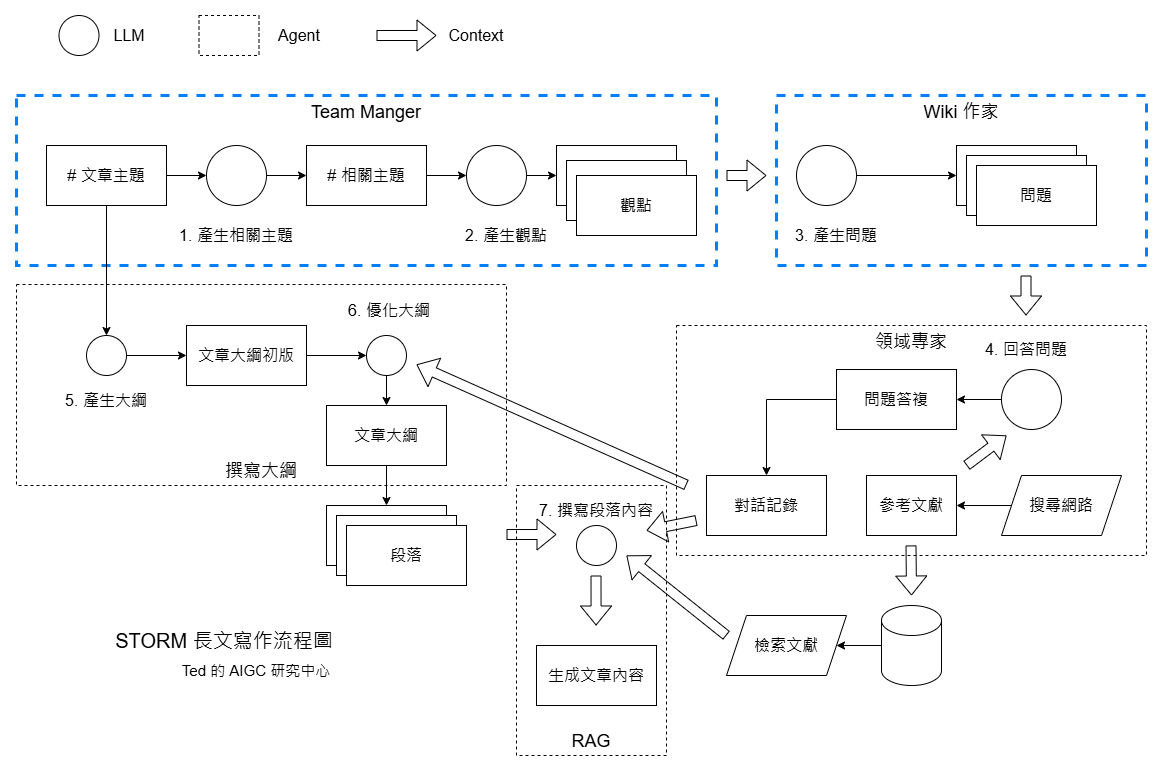

In [2]:
from litellm import completion, acompletion
import json

In [23]:
def generate_related_topics(topic: str) -> list[str]:
    system_prompt = """我想寫一篇關於某個主題的長篇文章。我會給你主題，我希望你能提出 3 個相關的子主題來擴展內容。
    
    請以 JSON 格式回應，格式如下:
    {
        "subtopics": [
            {"title": "子主題1", "description": "簡短描述"},
            {"title": "子主題2", "description": "簡短描述"},
            {"title": "子主題3", "description": "簡短描述"}
        ]
    }
    """

    user_prompt = """這裏是主題:\n\n主題:{topic}"""
    try:
        response = completion(
            api_key=OPENAI_API_KEY,
            model="gpt-3.5-turbo",
            messages=[{"content": system_prompt, "role": "system"}, {"content": user_prompt.format(topic=topic), "role": "user"}],
            temperature=0.5,
            max_tokens=1000,
            response_format={"type": "json_object"}  # 啟用 JSON 模式
        )
        response_content = response.choices[0].message.content
        
        # 解析JSON回應
        import json
        parsed_response = json.loads(response_content)
        
        # 返回結構化數據
        return parsed_response["subtopics"]
    except Exception as e:
        print(f"Error in generating related topics: {e}")
        return []

In [24]:
topic = '建立一個專業的 LinkIn 首頁'
related_topics = generate_related_topics(topic)

In [25]:
from pprint import pprint

pprint(related_topics)


[{'description': '如何設計一個專業的個人資料頁面', 'title': '設計個人資料'},
 {'description': '如何撰寫引人注目的個人簡介及經歷', 'title': '內容豐富'},
 {'description': '如何擴展人脈及建立專業形象', 'title': '網絡建立'}]


In [29]:
def generate_perspectives(topic: str, related_topics: str) -> list[dict]:
    system_prompt = """
    你需要選擇一組由 3 位作家組成的團隊，他們將共同撰寫一篇關於這個主題的綜合性文章。
    每位作家都代表與此主題相關的不同觀點、角色或隸屬關係。
    你可以使用其他相關主題作為靈感。對於每個角色，添加他們將重點關注的描述。
    
    請以 JSON 格式回應，格式如下:
    {
        "writers": [
            {"title": "第一位作家的職稱", "perspective": "第一位作家的觀點描述"},
            {"title": "第二位作家的職稱", "perspective": "第二位作家的觀點描述"},
            {"title": "第三位作家的職稱", "perspective": "第三位作家的觀點描述"}
        ]
    }
    """

    user_prompt = """這裏是主題:\n\n
                    主題:{topic}\n\n
                    相關主題: {related_topics}"""
    try:
        print(user_prompt.format(topic=topic, related_topics=related_topics))
        print("-------------")
        response = completion(
            api_key = OPENAI_API_KEY,
            model="gpt-3.5-turbo",
            messages=[{ "content": system_prompt, "role": "system"},
                      { "content": user_prompt.format(topic=topic, related_topics=related_topics), "role": "user"}],
            temperature=0.5,
            max_tokens=1000,
            response_format={"type": "json_object"}  # 啟用 JSON 模式
        )
        response_content = response.choices[0].message.content
        
        # 解析JSON回應
        import json
        parsed_response = json.loads(response_content)
        
        # 返回結構化數據
        return parsed_response["writers"]
    except Exception as e:
        print(f"Error in generating perspectives: {e}")
        return []

In [30]:
perspectives = generate_perspectives(topic, related_topics)

pprint(perspectives)

這裏是主題:


                    主題:建立一個專業的 LinkIn 首頁


                    相關主題: [{'title': '設計個人資料', 'description': '如何設計一個專業的個人資料頁面'}, {'title': '內容豐富', 'description': '如何撰寫引人注目的個人簡介及經歷'}, {'title': '網絡建立', 'description': '如何擴展人脈及建立專業形象'}]
-------------
[{'perspective': '專注於如何設計一個專業的個人資料頁面，包括佈局、顏色選擇和視覺元素的設計', 'title': '設計師'},
 {'perspective': '專注於如何撰寫引人注目的個人簡介及經歷，確保內容豐富、有吸引力並突出重點', 'title': '內容編輯'},
 {'perspective': '專注於如何擴展人脈及建立專業形象，包括與他人互動、分享內容以及網絡建立的技巧', 'title': '社交專家'}]


In [34]:
perspectives

[{'title': '設計師', 'perspective': '專注於如何設計一個專業的個人資料頁面，包括佈局、顏色選擇和視覺元素的設計'},
 {'title': '內容編輯', 'perspective': '專注於如何撰寫引人注目的個人簡介及經歷，確保內容豐富、有吸引力並突出重點'},
 {'title': '社交專家', 'perspective': '專注於如何擴展人脈及建立專業形象，包括與他人互動、分享內容以及網絡建立的技巧'}]

In [86]:
system_prompt = """
你是一位經驗豐富的作家，想要編輯一篇關於特定主題的長篇文章。除了作為作家的身份外，你在研究主題時還有一個特定的觀點。
現在，你正在與一位專家交談以獲取資訊。請提出好問題以獲取更有用的訊息。
你一次只問一個問題，不要重複之前已經問過的問題。除了生成問題外，不要添加任何額外內容。
你的問題應該與你想寫的主題相關。

請以 JSON 格式回應，格式如下:
{{
    "question": "你生成的問題"
}}

對話歷史：{history}
"""

# 初始化對話歷史
history = []

# 將歷史記錄轉換為字符串
context = "\n".join(history)

# 格式化系統提示
formatted_prompt = system_prompt.format(history=context)


formatted_prompt

'\n你是一位經驗豐富的作家，想要編輯一篇關於特定主題的長篇文章。除了作為作家的身份外，你在研究主題時還有一個特定的觀點。\n現在，你正在與一位專家交談以獲取資訊。請提出好問題以獲取更有用的訊息。\n你一次只問一個問題，不要重複之前已經問過的問題。除了生成問題外，不要添加任何額外內容。\n你的問題應該與你想寫的主題相關。\n\n請以 JSON 格式回應，格式如下:\n{\n    "question": "你生成的問題"\n}\n\n對話歷史：\n'

In [89]:
def generate_question(topic: str, perspective: dict, history: list[str]):
    system_prompt = """
    你是一位經驗豐富的作家，想要編輯一篇關於特定主題的長篇文章。除了作為作家的身份外，你在研究主題時還有一個特定的觀點。
    現在，你正在與一位專家交談以獲取資訊。請提出好問題以獲取更有用的訊息。
    你一次只問一個問題，不要重複之前已經問過的問題。除了生成問題外，不要添加任何額外內容。
    你的問題應該與你想寫的主題相關。
    
    請以 JSON 格式回應，格式如下:
    {{
        "question": "你生成的問題"
    }}

    對話歷史：{history}
    """

    user_prompt = """這裏是主題:\n\n
                    主題:{topic}\n\n
                    你的身份: {title}\n\n
                    你的特定觀點: {perspective}\n\n
                    問題:"""

    context = "\n".join(history)

    try:
        # 從 perspective 字典中提取標題和觀點
        writer_title = perspective.get("title", "未指定職稱")
        writer_perspective = perspective.get("perspective", "未指定觀點")
        
        response = completion(
            api_key = OPENAI_API_KEY,
            model="gpt-4o",
            messages=[
                {"content": system_prompt.format(history=context), "role": "system"},
                {"content": user_prompt.format(
                    topic=topic, 
                    title=writer_title,
                    perspective=writer_perspective
                ), "role": "user"}
            ],
            temperature=0.5,
            max_tokens=1000,
            response_format={"type": "json_object"}  # 啟用 JSON 模式
        )
        response_content = response.choices[0].message.content
        

        # 解析JSON回應
        import json
        parsed_response = json.loads(response_content)
        
        # 返回問題
        return parsed_response["question"]
    except Exception as e:
        print(f"Error in generating question: {e}")
        return "無法生成問題，請重試。"
    


In [90]:
res = generate_question(topic, perspectives[0], [])
res


'在設計 LinkedIn 個人資料頁面的佈局時，哪些元素應該被優先考慮以確保專業性和視覺吸引力？'

# 同學的練習
- 思考你要撰寫的幾個主題
- 重複執行上面幾個動作
- 給同學 5 分鐘的時間練習


# 程式說明二、與領域專家的討論

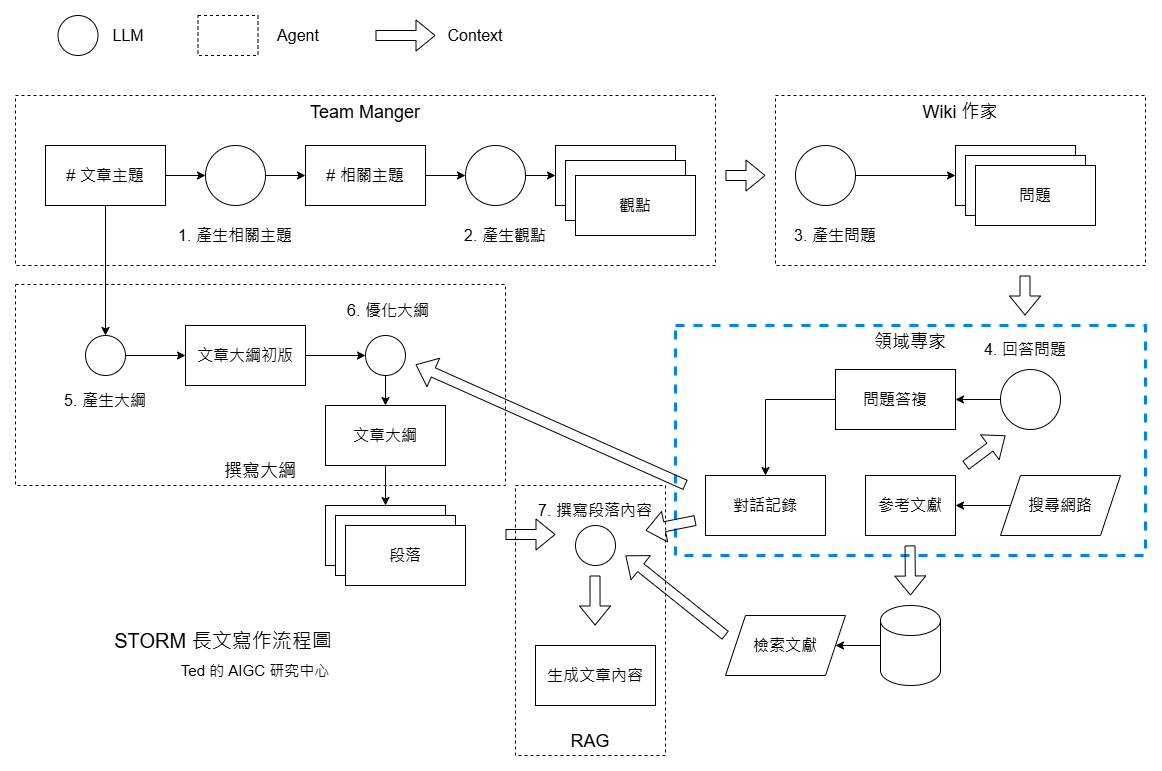

In [91]:
def generate_answer(topic: str, question: str, context: str):
    system_prompt = """
    你是一位能有效運用資訊的專家。你正在與一位作家交談，該作家想撰寫一篇關於你所熟悉的主題的文章。
    你已經收集了相關資訊，現在將使用這些資訊來形成回應。請確保你的回應盡可能提供豐富資訊，並確保每個句子都由收集到的資訊支持。

    相關資訊：{context}
    """

    user_prompt = """這裏是主題:\n\n
                    主題:{topic}\n\n
                    問題: {question}"""
    try:

        response = completion(
            api_key = OPENAI_API_KEY,
            model="gpt-4o",
            messages=[{ "content": system_prompt.format(context=context),"role": "system"},{ "content": user_prompt.format(topic=topic, question=question),"role": "user"}],
            temperature=0.5,
            max_tokens=1000,
        )
        response = response.choices[0].message.content

        return response
    except Exception as e:
        print(f"Error in translation: {e}")


In [45]:
# 設定環境變數
# from google.colab import userdata
from tavily import TavilyClient

# 建立 Tavily Search 的用戶端
# TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')

tavily = TavilyClient(api_key=TAVILY_API_KEY)

## 爬蟲模式 + tavily

In [124]:
all_conversations = []  # 這裏記錄的是所有的對話記錄
references = [] # 這裏記錄所有網路搜尋的結果
duplicate_references = set()
total_questions = 3 # 這裏設定每個觀點的問題詢問數量

# 使用 requests 和 BeautifulSoup 獲取完整網頁內容
import requests
from bs4 import BeautifulSoup
import time

def get_full_content(url, max_retries=3):
    """獲取網頁的完整內容"""
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    for attempt in range(max_retries):
        try:
            response = requests.get(url, headers=headers, timeout=10)
            response.raise_for_status()
            
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # 移除不需要的元素
            for tag in soup.find_all(['script', 'style', 'nav', 'footer', 'header']):
                tag.decompose()
                
            # 嘗試找到主要內容區域
            main_content = None
            for selector in ['main', 'article', '.content', '#content', '.post', '.article']:
                main_content = soup.select_one(selector)
                if main_content:
                    break
            
            # 如果找不到特定內容區，使用 body
            if not main_content:
                main_content = soup.body
                
            if main_content:
                # 提取文本並清理
                text = main_content.get_text(separator='\n', strip=True)
                # 移除多餘空行
                text = '\n'.join(line for line in text.split('\n') if line.strip())
                return text
            return "無法提取內容"
            
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(1)  # 重試前等待
            else:
                return f"提取失敗: {str(e)}"

# 這裏處理所有的特殊觀點
# 如果要產生所有觀點的問題請打開下面註解
for p in perspectives:
# for p in perspectives[:1]:
    print(f'產生 {p} 觀點問題：')

    history = []  # 這裏記錄目前這個觀點的對話記錄

    # 每個觀點都會詢問 {total_questions} 個問題
    for i in range(total_questions):
        # 產生問題
        question = generate_question(topic, p, history)
        print(f"QUESTION: {question}")

        # 增加問題記錄
        history.append(question)

        # 使用 Tavily search 來搜尋問題的網路資源
        try:
            # 如果查詢過長，截斷到900字元
            safe_query = question[:900] if len(question) > 900 else question
            tavily_response = tavily.search(query=safe_query, max_results=3, search_depth="advanced")
            results = tavily_response['results']
        except Exception as e:
            print(f"Tavily 搜索出錯: {e}")
            results = []

        # 所有搜尋到的資料我們會將它彙整到一個 context 結構裏面
        all_context = ""
        for result in results:
            print(f"標題: {result['title']}")
            print(f"URL: {result['url']}")
            
            # 嘗試獲取完整內容
            try:
                full_content = get_full_content(result['url'])
                # 如果獲取成功，使用完整內容；否則使用 Tavily 提供的摘要
                if "提取失敗" not in full_content and len(full_content) > len(result['content']):
                    content = full_content
                    print(f"使用完整內容 ({len(content)} 字元)")
                else:
                    content = result['content']
                    print(f"使用 Tavily 摘要 ({len(content)} 字元)")
            except Exception as e:
                content = result['content']
                print(f"內容提取出錯，使用 Tavily 摘要: {e}")
            
            all_context += content + "\n\n"

            # 是否之前已經有查詢到一樣的網絡資源？ 有重複的就跳過它
            if result['url'] in duplicate_references:
                continue

            # for 重複網絡資源判斷
            duplicate_references.add(result['url'])

            # 參考的儲存結果 for RAG system
            references.append({"title": result['title'], "source": result['url'], "content": content})

        # 領域專家的回答
        answer = generate_answer(topic, question, all_context)

        # 將回覆記錄增加到 history 對話歷史記錄中
        print(f"ANSWER: {answer}")
        print("-------")
        history.append(answer)

    # 將這次觀點的對話記錄存到所有對話記錄的結構中
    all_conversations.append(history)
print("DONE.")

產生 {'title': '設計師', 'perspective': '專注於如何設計一個專業的個人資料頁面，包括佈局、顏色選擇和視覺元素的設計'} 觀點問題：
QUESTION: 在設計一個專業的 LinkedIn 頁面時，哪些佈局元素最能有效地吸引潛在雇主的注意？
標題: LinkedIn公司專頁| 5個錦囊妙計，設計出有吸引力的公司頁面
URL: https://www.shutterstock.com/zh-Hant/blog/tips-designing-company-linkedin-profile
使用 Tavily 摘要 (100 字元)
標題: LinkedIn 個人品牌：職業成功策略- PLAG - 剽竊。學習。人工智慧.
URL: https://blog.plag.ai/zh-TW/linkedin-personal-branding
使用完整內容 (9673 字元)
標題: 如何建立职业页面？+ 11 个职业网站范例为您提供灵感 - Recruit CRM
URL: https://recruitcrm.io/zh-hans/blogs-zh/careers-page/
使用完整內容 (7941 字元)
ANSWER: 在設計一個專業的 LinkedIn 頁面時，有幾個關鍵的佈局元素可以有效地吸引潛在雇主的注意：

1. **個人資料圖片和橫幅**：選擇一張清晰、專業的個人照片，這是給潛在雇主的第一印象。橫幅圖片應該反映您的專業身份或行業精神，增強專業形象。

2. **引人注目的標題**：您的標題不僅僅是職位名稱，還應該簡潔地傳達您的專業知識和獨特價值。這是吸引潛在雇主的關鍵元素之一。

3. **摘要部分**：使用摘要來講述一個使您的職業道路栩栩如生的故事，重點介紹您獨特的見解和成功。這是展示您個人品牌和專業成就的絕佳機會。

4. **詳細的經驗描述**：在經驗部分，不僅僅列出職位名稱，還要詳細描述您的角色和成就，並使用可量化的指標來展示您的影響力。

5. **多媒體元素**：在您的經驗部分中加入影片、簡報和作品圖像等多媒體元素，以生動地展示您的專業貢獻和影響。

6. **技能和推薦**：列出相關的技能，並獲得同事或客戶的推薦，這不僅提高了您的可信度，也展示了您的專業能力。

7. **動態參與**：定期分享展示您專業知識的原創

## tavily mode

In [118]:
all_conversations = []  # 這裏記錄的是所有的對話記錄
references = [] # 這裏記錄所有網路搜尋的結果
duplicate_references = set()
total_questions = 3 # 這裏設定每個觀點的問題詢問數量

# 這裏處理所有的特殊觀點
# 如果要產生所有觀點的問題請打開下面註解
#for p in perspectives:
for p in perspectives[:1]:
    print(f'產生 {p} 觀點問題：')

    history = []  # 這裏記錄目前這個觀點的對話記錄

    # 每個觀點都會詢問 {total_questions} 個問題
    for i in range(total_questions):
        # 產生問題
        question = generate_question(topic, p, history)
        print(f"QUESTION: {question}")

        # 增加問題記錄
        history.append(question)

        # 使用 Tavily search 來搜尋問題的網路資源
        tavily_response = tavily.search(query=question, max_results=3, search_depth="advanced")
        results = tavily_response['results']

        # 所有搜尋到的資料我們會將它彙整到一個 context 結構裏面
        all_context = ""
        for result in results:

            print(result)
            
            all_context += result['content'] + "\n"

            # 是否之前已經有查詢到一樣的網絡資源？ 有重複的就跳過它
            if result['url'] in duplicate_references:
                continue

            # for 重複網絡資源判斷
            duplicate_references.add(result['url'])

            # 參考的儲存結果 for RAG system
            references.append({"title": result['title'], "source": result['url'], "content": result['content']})

        # 領域專家的回答
        answer = generate_answer(topic, question, all_context)

        # 將回覆記錄增加到 history 對話歷史記錄中
        print(f"ANSWER: {answer}")
        print("-------")
        history.append(answer)

    # 將這次觀點的對話記錄存到所有對話記錄的結構中
    all_conversations.append(history)
print("DONE.")



產生 {'title': '設計師', 'perspective': '專注於如何設計一個專業的個人資料頁面，包括佈局、顏色選擇和視覺元素的設計'} 觀點問題：
QUESTION: 在設計一個專業的 LinkedIn 個人資料頁面時，您認為哪些佈局元素對於提升整體專業形象最為重要？
{'url': 'https://www.shutterstock.com/zh-Hant/blog/tips-designing-company-linkedin-profile', 'title': 'LinkedIn公司專頁| 5個錦囊妙計，設計出有吸引力的公司頁面', 'content': '你有沒有發現視覺效果對LinkedIn公司專頁很重要？新增橫幅圖片並上傳商標以增加存在感是個妙策。當會員搜尋你的公司或你的員工資料時，商標就會出現。', 'score': 0.63452125, 'raw_content': None}
{'url': 'https://www.facebook.com/groups/213880764995293/posts/300729616310407/', 'title': '5分钟手把手教你学会制作高级感LinkedIn Banner图 ... - Facebook', 'content': '根据B2B性质和LinkedIn banner图的排版布局，我给大家整理了几个非常适合大 家使用的模板（所有用户可使用）： （大家可以搜索右上角的关键词，直接搜出这三个', 'score': 0.2423988, 'raw_content': None}
{'url': 'https://business.linkedin.com/content/dam/me/business/zh-cn/marketing-solutions/campaign/2020/may/sophisticated-marketers-guide-to-global-content_CN_final.pdf', 'title': '[PDF] 全球内容挑战 - LinkedIn Business', 'content': '横跨不同市场有效调动和利用品牌内容，是. 大有可为的。如果能合理全球内容策略，您. 就可以创造更多有效内容，实现更好营销效. 果，超额完成本地营销目标。相反，如

In [121]:
references[0]["content"]

'你有沒有發現視覺效果對LinkedIn公司專頁很重要？新增橫幅圖片並上傳商標以增加存在感是個妙策。當會員搜尋你的公司或你的員工資料時，商標就會出現。'

In [94]:
## Q A
all_conversations

[['在設計 LinkedIn 個人資料頁面時，哪些佈局策略可以幫助突出專業形象並增強可讀性？',
  '在設計 LinkedIn 個人資料頁面以突出專業形象並增強可讀性時，有幾個佈局策略可以考慮：\n\n1. **專業的個人頭像與背景圖**：選擇一張能代表您專業形象的頭像，保持乾淨簡潔的風格。背景圖可以用來展示企業的業務範疇或核心產品，進一步強化您的專業身份。\n\n2. **引人入勝的封面故事**：在 LinkedIn 個人資料中添加影片介紹，使其更具吸引力和風度。這不僅能顯著提高參與度，還能給訪客留下深刻印象。\n\n3. **精心撰寫的摘要**：利用個人資料的摘要部分來講述您的職業故事，展示關鍵職業時刻、克服的挑戰和實現的里程碑。這種敘事策略能夠吸引讀者的注意，並增強您的專業形象。\n\n4. **定期更新與反映現狀**：保持個人資料的動態性，定期更新以準確反映您目前的職業狀態和能力。這能夠保持其相關性和吸引力，對潛在雇主和合作者更具吸引力。\n\n5. **使用關鍵字進行SEO優化**：在個人資料中使用與您行業和技能相關的關鍵字，這能提高在 LinkedIn 和外部搜尋引擎上的可見度，吸引合適的受眾。\n\n6. **隱私和設定管理**：管理您的隱私設置，以控制哪些資訊是公開的，以及誰可以看到您的活動和聯繫。這有助於維護您的個人品牌的完整性。\n\n透過這些策略，您可以確保您的 LinkedIn 個人資料不僅專業且具吸引力，還能有效地傳達您的職業價值和成就，成為促進職業關係和發展的有力工具。',
  '在選擇 LinkedIn 個人資料的顏色方案時，有哪些顏色能夠有效傳達專業性並與品牌形象相符？',
  '在選擇 LinkedIn 個人資料的顏色方案時，考慮到專業性和品牌形象的傳達，以下幾種顏色是有效的選擇：\n\n1. **LinkedIn Blue**：LinkedIn 的標誌性藍色是專業和信任的象徵，這使得它成為 LinkedIn 個人資料的理想選擇。這種顏色不僅與平台的整體設計相匹配，還能有效提升品牌一致性。\n\n2. **黑色**：黑色是一種經典且永不過時的顏色，能夠傳達出專業性和權威感。它適合作為強調色或背景色，特別是在需要突出其他元素時。\n\n3. **白色**：白色背景能夠提供清晰和整潔的外觀，讓其他顏色和內容更加突出。使用白色作為背景

# 同學的練習
- 挑選一個自己想要測試的主題
- 依序執行，並且確認正確無誤
- 給同學 5 分鐘的時間練習


# 程式說明三、建立大綱

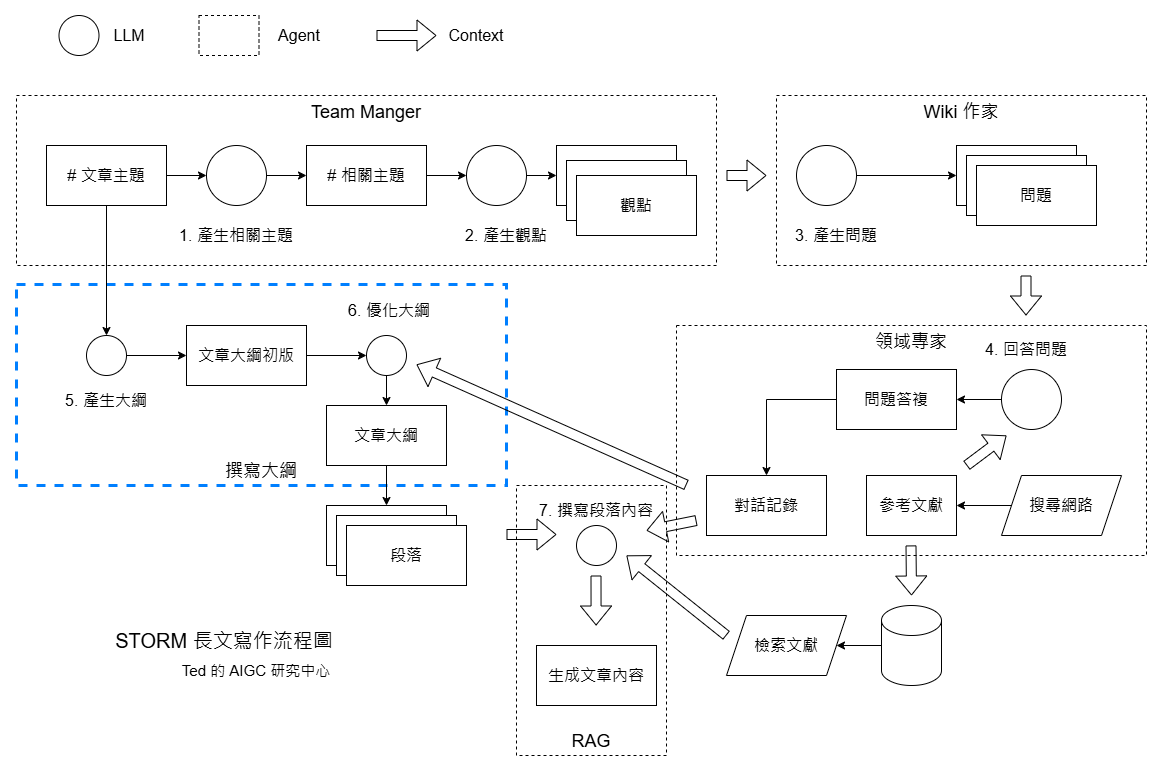

In [95]:
def generate_outline(topic: str) -> str:
    """
    產生初版文章大綱，請注意提示詞有做改進。
    """

    # system_prompt = """
    # 為一個特定主題撰寫文章大綱。
    # 這是你寫作的格式：
    # 使用“# 標題”來指示節的標題，“## 標題”來指示小節的標題，“### 標題”來指示小小節的標題，依此類推。
    # 不要包含其他資訊。請使用繁體中文。
    # """

    system_prompt = """
    為一個特定主題撰寫文章大綱。下方是你寫作的格式：

    1. 使用“# 標題”來指示節的標題。
    2. 使用“## 標題”來指示小節的標題。
    3. 使用“-”符號來列出小節中的要點。
    4. 每個節和小節之間請確保有空行。
    5. 大綱應僅包含標題和要點，不應包含其他額外資訊。
    6. 請使用繁體中文。
    """

    user_prompt = """這裏是主題:\n\n主題:{topic}"""

    try:

        response = completion(
            api_key = OPENAI_API_KEY,
            model="gpt-3.5-turbo",
            messages=[{ "content": system_prompt,"role": "system"},{ "content": user_prompt.format(topic=topic),"role": "user"}],
            temperature=0.5,
            max_tokens=500,
        )
        response = response.choices[0].message.content

        return response
    except Exception as e:
        print(f"Error in translation: {e}")


In [96]:
# 使用使用者指定的主題，產生主題大綱初版
outline = generate_outline(topic)

In [97]:
print(outline) # generated outline

# 建立一個專業的 LinkIn 首頁

## 簡介
- 介紹LinkedIn的重要性
- 目的是建立專業形象和職場網絡

## 個人資料
- 更新個人照片
- 撰寫引人注目的個人簡介
- 確保個人資訊完整

## 封面圖片
- 選擇專業且具吸引力的封面圖片
- 可以展示個人特色或興趣

## 經歷與學歷
- 詳細列出工作經歷
- 強調成就和專業技能
- 更新學歷資訊

## 推薦信
- 獲取同事或上司的推薦信
- 互相推薦以建立信任

## 社交互動
- 主動參與社群討論
- 分享專業知識和文章
- 互動回應他人的貼文

## 專業頭銜
- 使用具體和專業的頭銜
- 可以突顯個人專業性和能力

## 聯絡資訊
- 確保聯絡資訊是最新的
- 方便他人與你取得聯繫

## 精選作品
- 上傳展示自己專業能力的作品
- 可以是文章、研究報告、演講錄像等

## 頻繁更新
- 定期更新個人資訊和動態
- 保持與職場趨


In [103]:
def refine_outline(topic: str, outline: str, conversation: list[list[str]]) -> str:
    system_prompt = """
    我希望你改善一篇關於【{topic}】主題的文章大綱。
    你已經有一個涵蓋了一般資訊的初稿大綱，現在你希望基於與專家的對話中學到的資訊來改進它，使其更加全面。

    這是你寫作的格式：
    使用“# 標題”來指示節的標題，“## 標題”來指示小節的標題，“### 標題”來指示小小節的標題，依此類推。不要包含其他資訊。請使用繁體中文。

    初稿大綱：{outline}
    """

    user_prompt = """學到的資訊: {conversation}"""
    flattened_list = [item for sublist in conversation for item in sublist]
    context = ''.join(flattened_list)
    try:
        response = completion(
            api_key = OPENAI_API_KEY,
            model="gpt-4o",
            messages=[{ "content": system_prompt.format(topic=topic, outline=outline),"role": "system"},
                      { "content": user_prompt.format(conversation=context),"role": "user"}],
            temperature=0.5,
            max_tokens=1000,
        )
        response = response.choices[0].message.content

        return response
    except Exception as e:
        print(f"Error in translation: {e}")

In [104]:
refined_outline = refine_outline(topic, outline, all_conversations)

In [105]:
print(outline) # initial outline

# 建立一個專業的 LinkIn 首頁

## 簡介
- 介紹LinkedIn的重要性
- 目的是建立專業形象和職場網絡

## 個人資料
- 更新個人照片
- 撰寫引人注目的個人簡介
- 確保個人資訊完整

## 封面圖片
- 選擇專業且具吸引力的封面圖片
- 可以展示個人特色或興趣

## 經歷與學歷
- 詳細列出工作經歷
- 強調成就和專業技能
- 更新學歷資訊

## 推薦信
- 獲取同事或上司的推薦信
- 互相推薦以建立信任

## 社交互動
- 主動參與社群討論
- 分享專業知識和文章
- 互動回應他人的貼文

## 專業頭銜
- 使用具體和專業的頭銜
- 可以突顯個人專業性和能力

## 聯絡資訊
- 確保聯絡資訊是最新的
- 方便他人與你取得聯繫

## 精選作品
- 上傳展示自己專業能力的作品
- 可以是文章、研究報告、演講錄像等

## 頻繁更新
- 定期更新個人資訊和動態
- 保持與職場趨


In [106]:
print(refined_outline) # refined outline

# 建立一個專業的 LinkedIn 首頁

## 簡介
- 介紹LinkedIn的重要性
- 目的是建立專業形象和職場網絡

## 個人資料
- 更新專業的個人照片
- 撰寫引人注目的個人簡介
- 確保個人資訊完整

## 專業佈局策略
- 專業的個人頭像與背景圖
- 引人入勝的封面故事
- 精心撰寫的摘要
- 定期更新與反映現狀
- 使用關鍵字進行SEO優化
- 隱私和設定管理

## 視覺元素
- 選擇專業且具吸引力的封面圖片
- 使用品牌徽標增強品牌識別
- 一致的配色方案與字體選擇
- 添加影片介紹以提高參與度
- 內容一致性

## 經歷與學歷
- 詳細列出工作經歷
- 強調成就和專業技能
- 更新學歷資訊

## 推薦信
- 獲取同事或上司的推薦信
- 互相推薦以建立信任

## 社交互動
- 主動參與社群討論
- 分享專業知識和文章
- 互動回應他人的貼文

## 專業頭銜
- 使用具體和專業的頭銜
- 可以突顯個人專業性和能力

## 聯絡資訊
- 確保聯絡資訊是最新的
- 方便他人與你取得聯繫

## 精選作品
- 上傳展示自己專業能力的作品
- 可以是文章、研究報告、演講錄像等

## 頻繁更新
- 定期更新個人資訊和動態
- 保持與職場趨勢同步

## 顏色方案
- LinkedIn Blue作為信任象徵
- 黑色傳達專業性和權威感
- 白色背景提供清晰和整潔的外觀

通過這些策略和元素，您可以確保您的 LinkedIn 個人資料不僅專業且具吸引力，還能有效地傳達您的職業價值和成就，成為促進職業關係和發展的有力工具。


# 同學的練習
- 延續剛剛挑選的主題
- 接續執行，並且確認正確無誤
- 給同學 5 分鐘的時間練習

# 程式說明四、RAG & 段落內容的撰寫

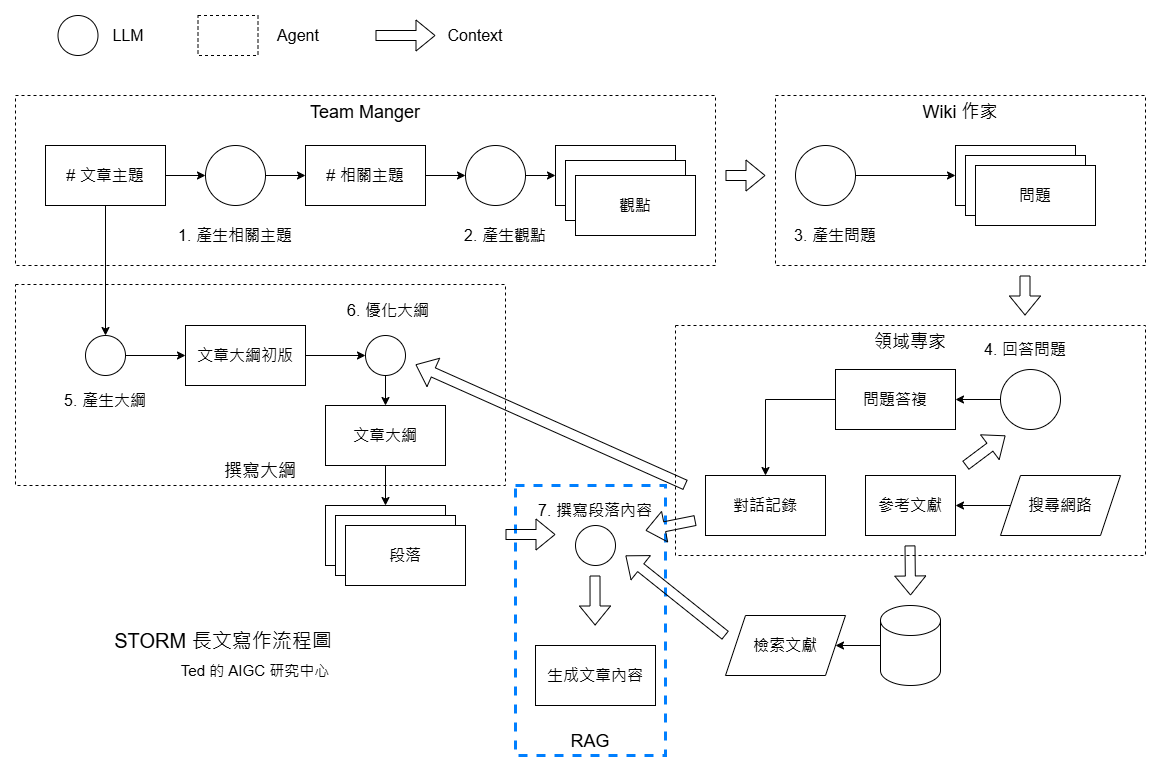

In [108]:
# 切割為撰寫段落
rr = refined_outline.split("\n\n")
rr


['# 建立一個專業的 LinkedIn 首頁',
 '## 簡介\n- 介紹LinkedIn的重要性\n- 目的是建立專業形象和職場網絡',
 '## 個人資料\n- 更新專業的個人照片\n- 撰寫引人注目的個人簡介\n- 確保個人資訊完整',
 '## 專業佈局策略\n- 專業的個人頭像與背景圖\n- 引人入勝的封面故事\n- 精心撰寫的摘要\n- 定期更新與反映現狀\n- 使用關鍵字進行SEO優化\n- 隱私和設定管理',
 '## 視覺元素\n- 選擇專業且具吸引力的封面圖片\n- 使用品牌徽標增強品牌識別\n- 一致的配色方案與字體選擇\n- 添加影片介紹以提高參與度\n- 內容一致性',
 '## 經歷與學歷\n- 詳細列出工作經歷\n- 強調成就和專業技能\n- 更新學歷資訊',
 '## 推薦信\n- 獲取同事或上司的推薦信\n- 互相推薦以建立信任',
 '## 社交互動\n- 主動參與社群討論\n- 分享專業知識和文章\n- 互動回應他人的貼文',
 '## 專業頭銜\n- 使用具體和專業的頭銜\n- 可以突顯個人專業性和能力',
 '## 聯絡資訊\n- 確保聯絡資訊是最新的\n- 方便他人與你取得聯繫',
 '## 精選作品\n- 上傳展示自己專業能力的作品\n- 可以是文章、研究報告、演講錄像等',
 '## 頻繁更新\n- 定期更新個人資訊和動態\n- 保持與職場趨勢同步',
 '## 顏色方案\n- LinkedIn Blue作為信任象徵\n- 黑色傳達專業性和權威感\n- 白色背景提供清晰和整潔的外觀',
 '通過這些策略和元素，您可以確保您的 LinkedIn 個人資料不僅專業且具吸引力，還能有效地傳達您的職業價值和成就，成為促進職業關係和發展的有力工具。']

In [111]:
# fastembed 是 qdrant 預設使用的 embedding 工具, 細節可參考： https://github.com/qdrant/fastembed
from fastembed import TextEmbedding
from typing import List

In [113]:
# 建立 RAG data source
documents = []
metadata = []
ids = []
for i in range(len(references)):
    documents.append(references[i]['title'] + " " + references[i]["content"])
    metadata.append({"source":references[i]["source"]})
    ids.append(i)



In [116]:
references

[{'title': 'B2B行銷最佳平台? 透過LinkedIn 高效發展客戶關係: 策略',
  'source': 'https://vocus.cc/article/670d573dfd89780001aed318',
  'content': '個人頁面優化:建立專業形象 · 建立專業的個人頭像與背景圖：盡量選擇能代表專業形象的照片，以乾淨簡潔的風格為主；背景圖則可展示企業的業務範疇或核心產品。'},
 {'title': 'LinkedIn 個人品牌：職業成功策略- PLAG - 剽竊。學習。人工智慧.',
  'source': 'https://blog.plag.ai/zh-TW/linkedin-personal-branding',
  'content': 'LinkedIn 個人品牌：職業成功的策略 努力讓您的 LinkedIn 個人資料為您服務，讓機會來敲您的門！ 為什麼 LinkedIn 在個人品牌建立方面脫穎而出 策略性地打造您的 LinkedIn 身分涉及幾個關鍵要素： 有效打造 LinkedIn 品牌的實用技巧 優化您的 LinkedIn 個人資料 封面故事。在您的 LinkedIn 個人資料中添加影片介紹，使其更具吸引力和風度。這可以顯著提高參與度並給個人資料訪客留下難忘的印象。 LinkedIn 個人品牌傳播策略 LinkedIn 上的有效人際網絡不僅是擴大您的聯絡人列表，還在於策略性地建立聯繫。專注於與符合您職涯目標並能影響您職涯發展的個人建立關係。參與與您的領域相關的小組和討論，以提高您的知名度並讓自己成為思想領袖。 利用 LinkedIn 分析 在優化您的 LinkedIn 個人資料並積極參與社群後，現在是時候利用這些改進來實現更具策略性和目的性的網路了。本節將重點從一般參與轉向專門建立和促進直接支持您的職業抱負的網絡，並製定與可以極大影響您的職業軌蹟的關鍵個人和團體建立聯繫的策略。 識別有影響力的成員。使用 LinkedIn 的搜尋和過濾工具來尋找您所在行業的關鍵人物並參與他們的內容。 團體參與。加入相關的 LinkedIn 群組，了解產業趨勢並建立思想領導。 透過整合這些策略，您可以將 LinkedIn 形象轉變為促進職業關係和發展職業生涯的動態工具。 使用 LinkedIn 分析 假設一位行銷顧問分析了其 Link

In [114]:
from qdrant_client import QdrantClient

client = QdrantClient(":memory:")

# 如果想要使用其他 embedding model，可如下指定
# client.set_model("sentence-transformers/all-MiniLM-L6-v2")
# 中文 embedding model
client.set_model("BAAI/bge-small-zh-v1.5")

# fastembed 支援的 models: https://qdrant.github.io/fastembed/examples/Supported_Models

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model_optimized.onnx:   0%|          | 0.00/94.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/739 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/439k [00:00<?, ?B/s]

c:\Users\SUNNIE.GD.WENG\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\SUNNIE.GD.WENG\AppData\Local\Temp\fastembed_cache\models--Qdrant--bge-small-zh-v1.5. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [125]:
client.delete_collection(collection_name="demo_collection")

True

In [126]:
# 建立 vector db
ids = client.add(
    collection_name="demo_collection",
    documents=documents,
    metadata=metadata,
    ids=ids
)

In [128]:
query = rr[1]
query

'## 簡介\n- 介紹LinkedIn的重要性\n- 目的是建立專業形象和職場網絡'

## RAG 檢索測試

In [129]:
search_result = client.query(
    collection_name="demo_collection",
    query_text=rr[1],
    limit=5
)

for s in search_result:
    print(s.metadata['source'])
    print(s.id)


https://vocus.cc/article/670d573dfd89780001aed318
0
https://blog.plag.ai/zh-TW/linkedin-personal-branding
1
https://jason-career.com/linkedin/?srsltid=AfmBOorvAc-5n1wXt1ku4MM-1GROxPIZpwZroVKKVZ-XRoCaDo4MJWke
2
https://tw.strikingly.com/blog/posts/mastering-social-media-branding-strategies-for-effective-online-presence
6
https://doisz.com/zh-CN/blog/presenca-consistente-no-linkedin-2/
5


In [130]:
search_result

[QueryResponse(id=0, embedding=None, sparse_embedding=None, metadata={'document': 'B2B行銷最佳平台? 透過LinkedIn 高效發展客戶關係: 策略 個人頁面優化:建立專業形象 · 建立專業的個人頭像與背景圖：盡量選擇能代表專業形象的照片，以乾淨簡潔的風格為主；背景圖則可展示企業的業務範疇或核心產品。', 'source': 'https://vocus.cc/article/670d573dfd89780001aed318'}, document='B2B行銷最佳平台? 透過LinkedIn 高效發展客戶關係: 策略 個人頁面優化:建立專業形象 · 建立專業的個人頭像與背景圖：盡量選擇能代表專業形象的照片，以乾淨簡潔的風格為主；背景圖則可展示企業的業務範疇或核心產品。', score=0.7029507513866668),
 QueryResponse(id=1, embedding=None, sparse_embedding=None, metadata={'document': 'LinkedIn 個人品牌：職業成功策略- PLAG - 剽竊。學習。人工智慧. LinkedIn 個人品牌：職業成功的策略 努力讓您的 LinkedIn 個人資料為您服務，讓機會來敲您的門！ 為什麼 LinkedIn 在個人品牌建立方面脫穎而出 策略性地打造您的 LinkedIn 身分涉及幾個關鍵要素： 有效打造 LinkedIn 品牌的實用技巧 優化您的 LinkedIn 個人資料 封面故事。在您的 LinkedIn 個人資料中添加影片介紹，使其更具吸引力和風度。這可以顯著提高參與度並給個人資料訪客留下難忘的印象。 LinkedIn 個人品牌傳播策略 LinkedIn 上的有效人際網絡不僅是擴大您的聯絡人列表，還在於策略性地建立聯繫。專注於與符合您職涯目標並能影響您職涯發展的個人建立關係。參與與您的領域相關的小組和討論，以提高您的知名度並讓自己成為思想領袖。 利用 LinkedIn 分析 在優化您的 LinkedIn 個人資料並積極參與社群後，現在是時候利用這些改進來實現更具策略性和目的性的網路了。本節將重點從一般參與轉向專門建立和促進直接支持您的職業抱負的網絡，並製定與可以極大影響您的職業

## 撰寫段落

In [131]:
def write_section(section: str) -> str:
    """
    撰寫段落文章
    """

    # 檢索該段落相關的網路資料
    search_result = client.query(
        collection_name="demo_collection",
        query_text=section,
        limit=5
    )

    # 產生參考文獻的文字格式
    references = generate_references_string(search_result)


    system_prompt = """
    你是寫作方面的專家。我會給你一個部落格的某一節的大綱和幾個參考資料。你需要使用提供的參考資料來生成該節的文章。
    你必須使用給定的來源來引用你的寫作。不要包含其他資訊。在這個格式中為每個句子包含“參考編號”：[ref_id]。你的回應必須以Markdown格式呈現。

    參考資料：{references}
    """


    user_prompt = """某一節的大綱: {section}"""

    try:
        response = completion(
            api_key = OPENAI_API_KEY,
            model="gpt-3.5-turbo",
            messages=[{ "content": system_prompt.format(references=references),"role": "system"},{ "content": user_prompt.format(section=section),"role": "user"}],
            temperature=0.5,
            max_tokens=1500,
        )
        response = response.choices[0].message.content

        return response
    except Exception as e:
        print(f"Error in translation: {e}")

In [132]:
def generate_references_string(references):
    output = []
    for ref in references:
        ref_id = ref.id
        ref_url = ref.metadata.get('source', '')
        ref_content = ref.metadata.get('document', '')

        # Construct a formatted string for each reference
        reference_str = f"Reference ID:\n {ref_id}\nURL: {ref_url}\nContent: {ref_content}\n"

        # Append the formatted reference string to the output list
        output.append(reference_str)

    return '\n'.join(output)

In [139]:
rr[1:]

['## 簡介\n- 介紹LinkedIn的重要性\n- 目的是建立專業形象和職場網絡',
 '## 個人資料\n- 更新專業的個人照片\n- 撰寫引人注目的個人簡介\n- 確保個人資訊完整',
 '## 專業佈局策略\n- 專業的個人頭像與背景圖\n- 引人入勝的封面故事\n- 精心撰寫的摘要\n- 定期更新與反映現狀\n- 使用關鍵字進行SEO優化\n- 隱私和設定管理',
 '## 視覺元素\n- 選擇專業且具吸引力的封面圖片\n- 使用品牌徽標增強品牌識別\n- 一致的配色方案與字體選擇\n- 添加影片介紹以提高參與度\n- 內容一致性',
 '## 經歷與學歷\n- 詳細列出工作經歷\n- 強調成就和專業技能\n- 更新學歷資訊',
 '## 推薦信\n- 獲取同事或上司的推薦信\n- 互相推薦以建立信任',
 '## 社交互動\n- 主動參與社群討論\n- 分享專業知識和文章\n- 互動回應他人的貼文',
 '## 專業頭銜\n- 使用具體和專業的頭銜\n- 可以突顯個人專業性和能力',
 '## 聯絡資訊\n- 確保聯絡資訊是最新的\n- 方便他人與你取得聯繫',
 '## 精選作品\n- 上傳展示自己專業能力的作品\n- 可以是文章、研究報告、演講錄像等',
 '## 頻繁更新\n- 定期更新個人資訊和動態\n- 保持與職場趨勢同步',
 '## 顏色方案\n- LinkedIn Blue作為信任象徵\n- 黑色傳達專業性和權威感\n- 白色背景提供清晰和整潔的外觀',
 '通過這些策略和元素，您可以確保您的 LinkedIn 個人資料不僅專業且具吸引力，還能有效地傳達您的職業價值和成就，成為促進職業關係和發展的有力工具。']

In [ ]:
article = ""

article = rr[0]
for section_outline in rr[1::]: # 列表切片語法，意思是從 rr 的第二個元素（索引為 1）開始，一直到列表的結尾
    sec = write_section(section_outline)
    article += sec + "\n\n"

print("article DONE!")


article DONE!


In [136]:
print(article)

# 建立一個專業的 LinkedIn 首頁## 簡介
LinkedIn作為專業社交平台在建立個人品牌和職場網絡中扮演著重要的角色。通過LinkedIn，個人能夠展示專業形象、擴展職業圈子，並為職涯發展打下堅實基礎。本節將探討如何最大程度地利用LinkedIn來建立個人品牌，提升職業成功。

## 個人資料

在建立您的個人品牌時，LinkedIn 個人資料是一個至關重要的元素。以下是幾個關鍵步驟，幫助您打造出令人印象深刻的個人資料：

1. **更新專業的個人照片**  
   當更新您的 LinkedIn 個人照片時，選擇一張專業且具有視覺吸引力的照片至關重要。照片的背景應該簡潔，並確保您的形象展現出專業性[4]。

2. **撰寫引人注目的個人簡介**  
   您的個人簡介是展示您專業背景和價值主張的絕佳機會。著重於您的專業成就、技能和經驗，讓人一目了然您的價值[1]。

3. **確保個人資訊完整**  
   確保您的個人資訊完整且最新。包括您的教育背景、工作經驗、技能專長和其他相關資訊。完整的個人資料有助於展示您的專業度和可靠性[0]。

## 專業佈局策略

在 LinkedIn 上建立專業形象是成功的關鍵之一。以下是一些重要策略，可幫助您打造引人注目的個人品牌：

### 1. 專業的個人頭像與背景圖
建立專業形象的第一步是確保您的個人頭像和背景圖片符合業界標準。個人頭像應選擇能代表專業形象的照片，背景圖則可展示企業的業務範圍或核心產品[0]。

### 2. 引人入勝的封面故事
在您的個人資料中添加一段引人入勝的封面故事，可以吸引訪客的注意並留下深刻印象。這有助於提高個人資料的參與度，展示您的獨特價值主張[1]。

### 3. 精心撰寫的摘要
利用 LinkedIn 的摘要部分展示您的專業故事和成就。詳細描述您的職業生涯的關鍵時刻，克服的挑戰以及您的核心價值觀，這有助於強化您的專業形象並建立更深層次的連接[1]。

### 4. 定期更新與反映現狀
持續更新您的個人資料，以準確反映您的最新職業狀態和能力。透過定期的更新，您可以確保個人資料的相關性和吸引力，讓潛在雇主和合作夥伴對您更感興趣[2]。

### 5. 使用關鍵字進行SEO優化
優化您的個人資料中的關鍵字，有助於提高在 LinkedIn 和外部搜索引擎上的可見性。這可以吸引更多符合您專業

In [145]:
with open('article_claude_1.md', 'w', encoding='utf-8-sig') as fout:
    fout.write(article)

In [143]:
references

[{'title': 'LinkedIn公司專頁| 5個錦囊妙計，設計出有吸引力的公司頁面',
  'source': 'https://www.shutterstock.com/zh-Hant/blog/tips-designing-company-linkedin-profile',
  'content': '1.新增橫幅與商標 · 2.設立令人印象深刻的展示專區(Showcase Page) · 3.分享訊息豐富且具吸引力的內容 · 4.最佳化LinkedIn公司專頁上的文案 · 5.使用LinkedIn'},
 {'title': 'LinkedIn 個人品牌：職業成功策略- PLAG - 剽竊。學習。人工智慧.',
  'source': 'https://blog.plag.ai/zh-TW/linkedin-personal-branding',
  'content': '←\n目錄\n目錄\n(\n)\n在當今的數位時代，在專業領域中脫穎而出不僅僅是一種必要，更是一種策略。這就是 LinkedIn，您的數位化平台\nCV\n網路巨頭介入。這是解鎖你的鑰匙\n職業潛力\n透過準備一個個人品牌，不僅能吸引你，也能讓你著迷和信服。您正在尋找夢想的工作或尋求將自己定位為行業領導者嗎？了解 LinkedIn 品牌的藝術是您邁向成功的第一步。\n在本指南中，我們將深入探討將您的 LinkedIn 個人資料從普通變為卓越的策略。您將學習如何完善個人資料的各個方面，從引人注目的標題到展示您專業知識的引人入勝的內容。此外，我們還將介紹如何有效地建立人際網絡並使用 LinkedIn 的豐富分析和高級功能來不斷適應並在您的職業生涯中蓬勃發展。\n努力讓您的 LinkedIn 個人資料為您服務，讓機會來敲您的門！\n為什麼 LinkedIn 在個人品牌建立方面脫穎而出\n與\nLinkedIn\n作為專業知名度的重要平台，透過策略性個人品牌來區分您的個人資料至關重要。與其他將個人軼事與專業內容結合的社交平台不同，LinkedIn 是職業發展和專業品牌的專用網路。在這裡，您創建的內容、建立的聯繫以及參與的互動都有助於塑造獨特的專業形象，以吸引招募人員、行業領導者和同行的注意。\n策略性地打造您的 LinkedIn 身分涉及幾個關鍵要素：\n量身訂製的視覺效果\n。確保您的

# 同學的練習
- 延續剛剛挑選的主題，接續執行，確認正確無誤
- 你可以使用 https://markdownlivepreview.com/ 來查看生成的結果
- 給同學 5 分鐘的時間練習